In [1]:
# Dictate the environment's loctaion of REFPROP
import os
os.environ['RPPREFIX'] = r'C:/Program Files (x86)/REFPROP'

In [2]:
# Import the main class from the Python library
from ctREFPROP.ctREFPROP import REFPROPFunctionLibrary

# Imports from conda-installable packages
import pandas as pd

# Import numpy
import numpy as np

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import Math for common values such as PI
import math


In [3]:
# Instantiate the library, and use the environment variable to explicitly state which path we want to use.
# As mentioned above, this will be changed to call the correct REFPROP functions to be used
# with MINI-REFPROP and 32-bit python.
# If using MINI-REFPROP and 32-bit python please make the following changes
# RP = REFPROPFunctionLibrary('C:/Program FIles (x86)/MINI-REFPROP\\REFPROP.DLL')
RP = REFPROPFunctionLibrary(os.environ['RPPREFIX'])

In [4]:
# This will call which root directory that will be used for the program. 
RP.SETPATHdll(os.environ['RPPREFIX'])

In [5]:
# Get the unit system we want to use (Mass base SI gives units in
# K, Pa, kg, m, N, J, W, and s)
MASS_BASE_SI = RP.GETENUMdll(0, "MASS BASE SI").iEnum

In [6]:
### Basic sCO2 States Derived

In [7]:
m_dot = .2 # kg/s of mass flow rate of sCO2

In [8]:
#### Outlet of Heat Source, Inlet of Engine

In [9]:
T3 = 85# [C]
P3 = 2500 # [psia]

T3 = T3 + 273.15 # Convert C to Kelvin
P3 = P3 * 6894.8 # convert psia to Pa

print("Pressure at Outlet of Heat Source =", P3/6894.8, "psia")
print("Temperature at Outlet of Heat Source =" , (T3 - 273.15) * (9/5) + 32, "F")

Pressure at Outlet of Heat Source = 2500.0 psia
Temperature at Outlet of Heat Source = 185.0 F


In [10]:
# Obtain fluid properties from the pressure and enthalpy outlined above
State_3 = RP.REFPROPdll("CO2","PT","H;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P3,T3,[1.0])

# Outputs will be placed into data frame for organization
State_3 = pd.DataFrame(State_3.Output[0:9],
            index = ['Enthalpy [J/kg]','Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 3'])

# Display the data frame
State_3

,State 3
Enthalpy [J/kg],406716.191506
Density [kg/m^3],480.660076
Volume [m^3/kg],0.002080
Entropy [J/kg],1597.215320
CP/CV,2.966649
Speed of Sound,294.198929
Thermal Cond. [W/(mK)],0.055155
Viscosity [Pa-s],0.000036
Prandtl,1.782125


In [11]:
#### Outlet of Engine, Inlet of Heat Exchanger

In [12]:
# Engine Parameters
mass_cylinder = State_3.loc['Density [kg/m^3]', 'State 3'] * .000308276
State_4_den = mass_cylinder / .000454574

# With Isentropic expansion
State_4_entr = State_3.loc['Entropy [J/kg]', 'State 3']

State_4_isen = RP.REFPROPdll("CO2","DS","P;T;V;H;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,State_4_den,State_4_entr,[1.0])

# Outputs will be placed into data frame for organization
State_4_isen = pd.DataFrame(State_4_isen.Output[0:9],
            index = ['Pressure [Pa]', 'Temperature [K]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 4 Isentropic'])


In [13]:
# Account for Issentropic Efficiency
Isen_eff = .7
State_4_enth_new = State_3.loc['Enthalpy [J/kg]','State 3'] - (Isen_eff * (State_3.loc['Enthalpy [J/kg]','State 3'] - State_4_isen.loc['Enthalpy [J/kg]', 'State 4 Isentropic']))

# Using Pressure and enthalpy find the states of the fluid at the Outlet of Engine

State_4 = RP.REFPROPdll("CO2","PH","D;T;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,State_4_isen.loc['Pressure [Pa]','State 4 Isentropic'],State_4_enth_new,[1.0])

# Outputs will be placed into data frame for organization
State_4 = pd.DataFrame(State_4.Output[0:9],
            index = ['Density [kg/m^3]','Temperature [K]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 4'])


In [14]:
#### Outlet of Heat Exchanger, Inlet to Compressor

In [15]:
P1 = State_4_isen.loc['Pressure [Pa]', 'State 4 Isentropic']

Q_out = -2.5 # kW heat removed by Heat Exchanger 2.5

h1 = Q_out * 1000 / (m_dot) + State_4_isen.loc['Enthalpy [J/kg]', 'State 4 Isentropic']

In [16]:
# Obtain fluid properties from the pressure and enthalpy outlined above
State_1 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P1,h1,[1.0])

# Outputs will be placed into data frame for organization
State_1 = pd.DataFrame(State_1.Output[0:9],
            index = ['Temperature [K]','Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 1'])

In [17]:
#### Outlet of Compressor, Inlet to Heat Source Isentropic

In [18]:
# Find the Isentropic Outlet of the Compressor
State_2_isen = RP.REFPROPdll("CO2","PS","T;D;V;H;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P3,State_1.loc['Entropy [J/kg]', 'State 1'],[1.0])
State_2_isen = pd.DataFrame(State_2_isen.Output[0:9],
            index = ['Temperature [K]','Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 2 Isentropic'])

In [19]:
# Account for Issentropic Efficiency
Isen_eff = .85
State_2_enth_new = h1 + ((State_2_isen.loc['Enthalpy [J/kg]', 'State 2 Isentropic'] - h1)/Isen_eff)

In [20]:
State_2 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P3,State_2_enth_new,[1.0])

# Outputs will be placed into data frame for organization
State_2 = pd.DataFrame(State_2.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 2'])

In [21]:
State_3.loc['Pressure [Pa]', 'State 3'] = P3
State_3.loc['Temperature [K]', 'State 3'] = T3
State_4_isen.loc['Density [kg/m^3]', 'State 4 Isentropic'] = State_4_den
State_4_isen.loc['Entropy [J/kg]', 'State 4 Isentropic'] = State_4_entr
State_4.loc['Enthalpy [J/kg]', 'State 4'] = State_4_enth_new
State_4.loc['Pressure [Pa]', 'State 4'] = State_4_isen.loc['Pressure [Pa]','State 4 Isentropic']
State_1.loc['Pressure [Pa]', 'State 1'] = P1
State_1.loc['Enthalpy [J/kg]', 'State 1'] = h1
State_2_isen.loc['Entropy [J/kg]', 'State 2 Isentropic'] = State_1.loc['Entropy [J/kg]', 'State 1']
State_2_isen.loc['Pressure [Pa]', 'State 2 Isentropic'] = P3
State_2.loc['Enthalpy [J/kg]', 'State 2'] = State_2_enth_new
State_2.loc['Pressure [Pa]', 'State 2'] = State_2_isen.loc['Pressure [Pa]', 'State 2 Isentropic']

In [22]:
# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([State_1, State_2_isen, State_2, State_3, State_4_isen, State_4], axis =1)

# Reorder the Data Frame
sCO2_States = sCO2_States.reindex(["Pressure [Pa]", "Temperature [K]", 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'Entropy [J/kg]', 'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 
                     'Prandtl' ])

# Display the data frame
sCO2_States

,State 1,State 2 Isentropic,State 2,State 3,State 4 Isentropic,State 4
Pressure [Pa],8.142864e+06,1.723700e+07,1.723700e+07,1.723700e+07,8.142864e+06,8.142864e+06
Temperature [K],3.101153e+02,3.530416e+02,3.543074e+02,3.581500e+02,3.113238e+02,3.122069e+02
Density [kg/m^3],3.606617e+02,5.148984e+02,5.060638e+02,4.806601e+02,3.259667e+02,3.091700e+02
Volume [m^3/kg],2.772681e-03,1.942131e-03,1.976035e-03,2.080472e-03,3.067798e-03,3.234467e-03
Enthalpy [J/kg],3.719603e+05,3.924099e+05,3.960187e+05,4.067162e+05,3.844603e+05,3.911371e+05
Entropy [J/kg],1.556980e+03,1.556980e+03,1.567184e+03,1.597215e+03,1.597215e+03,1.618632e+03
CP/CV,1.084347e+01,3.092798e+00,3.064922e+00,2.966649e+00,7.509643e+00,6.283907e+00
Speed of Sound,1.912395e+02,3.003353e+02,2.985367e+02,2.941989e+02,1.971360e+02,2.005064e+02
Thermal Cond. [W/(mK)],6.425538e-02,5.809879e-02,5.733734e-02,5.515481e-02,5.466991e-02,5.036067e-02
Viscosity [Pa-s],2.575052e-05,3.848092e-05,3.781603e-05,3.600559e-05,2.400834e-05,2.325274e-05


In [23]:
# Plot States on T-S Diagram
S_CO2_1 = []
S_CO2_2 = []
T_CO2 = []
T = 273.125 # K

for x in range(0,20000):
    CO2_S = RP.REFPROPdll("CO2","TQMASS","S", MASS_BASE_SI,0,0, T + 31*(x/20000), 0,[1.0]).Output[0]
    S_CO2_1.append(CO2_S/1000)
    CO2_S = RP.REFPROPdll("CO2","TQMASS","S", MASS_BASE_SI,0,0, T + 31*(x/20000), 1,[1.0]).Output[0]
    S_CO2_2.append(CO2_S/1000)
    T_CO2.append(T + 31*(x/20000))

In [24]:
T_CO2_P1 = []
T_CO2_P2 = []
S_P1 = []
T_CO2_P3 = []

for x in range(0,1000):
    CO2_T = RP.REFPROPdll("CO2","PS","T", MASS_BASE_SI,0,0, 1.723700e+07, (1 + .8 * (x/1000))*1000 ,[1.0]).Output[0]
    T_CO2_P1.append(CO2_T-273.125)
    S_P1.append(1 + .8 * (x/1000))
    CO2_T = RP.REFPROPdll("CO2","PS","T", MASS_BASE_SI,0,0, 8.142864e+06, (1 + .8 * (x/1000))*1000 ,[1.0]).Output[0]
    T_CO2_P2.append(CO2_T-273.125)

In [25]:
Isentropic_T = [sCO2_States.loc['Temperature [K]', 'State 2 Isentropic'],sCO2_States.loc['Temperature [K]', 'State 3'],sCO2_States.loc['Temperature [K]', 'State 4 Isentropic'],\
                sCO2_States.loc['Temperature [K]', 'State 1'],sCO2_States.loc['Temperature [K]', 'State 2 Isentropic'] ]
Actual_T = [sCO2_States.loc['Temperature [K]', 'State 2'],sCO2_States.loc['Temperature [K]', 'State 3'],sCO2_States.loc['Temperature [K]', 'State 4'],\
                sCO2_States.loc['Temperature [K]', 'State 1'],sCO2_States.loc['Temperature [K]', 'State 2'] ]
S_Isentropic = [sCO2_States.loc['Entropy [J/kg]', 'State 2 Isentropic'],sCO2_States.loc['Entropy [J/kg]', 'State 3'],sCO2_States.loc['Entropy [J/kg]', 'State 4 Isentropic'],\
                sCO2_States.loc['Entropy [J/kg]', 'State 1'],sCO2_States.loc['Entropy [J/kg]', 'State 2 Isentropic'] ]
S_Actual = [sCO2_States.loc['Entropy [J/kg]', 'State 2'],sCO2_States.loc['Entropy [J/kg]', 'State 3'],sCO2_States.loc['Entropy [J/kg]', 'State 4'],\
                sCO2_States.loc['Entropy [J/kg]', 'State 1'],sCO2_States.loc['Entropy [J/kg]', 'State 2'] ]


In [26]:
T_merge = [31,31]
S_merge = [1.415, 1.45]
Isentropic_T = np.array(Isentropic_T) - 273.125
Actual_T = np.array(Actual_T) - 273.125
S_Isentropic = np.array(S_Isentropic)/1000
S_Actual = np.array(S_Actual)/1000
T_CO2 = np.array(T_CO2) - 273.125

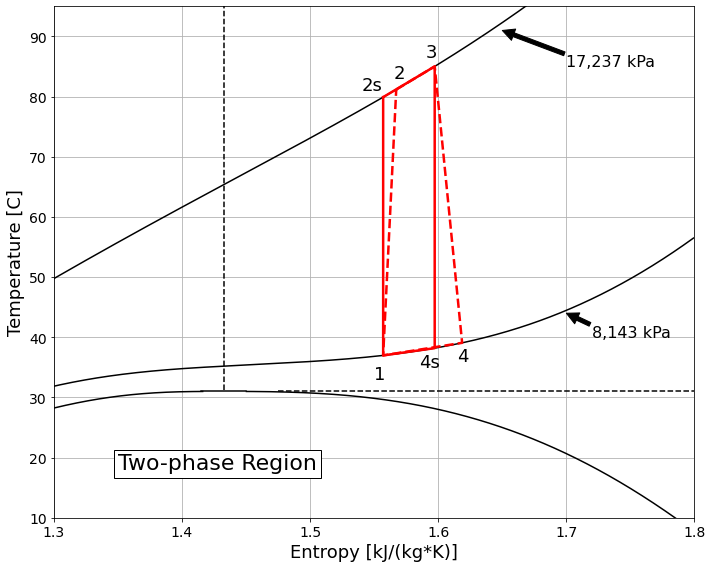

In [27]:
plt.figure(figsize=(10,8), tight_layout=True)

plt.plot(S_CO2_1, T_CO2, 'k', linewidth = 1.5 )
plt.plot(S_CO2_2, T_CO2, 'k', linewidth = 1.5 )
plt.plot(S_merge, T_merge,'k', linewidth = 1.5)
plt.plot(S_P1, T_CO2_P1,'k',linewidth=1.5)
plt.plot(S_P1, T_CO2_P2,'k',linewidth=1.5)
plt.axvline(x = 1.4331, ymin= .25,  color = 'k', linestyle = '--')
plt.axhline(y=31, xmin = .35, color = 'k', linestyle = '--')
plt.plot(S_Isentropic, Isentropic_T, '-r', linewidth = 2.5)
plt.plot(S_Actual, Actual_T, '--r', linewidth = 2.5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.xlabel('Entropy [kJ/(kg*K)]', fontsize = 18)
plt.ylabel('Temperature [C]', fontsize = 18)
plt.axis([1.3,1.8,10,95])
plt.annotate('8,143 kPa', xy = (1.7, 44), fontsize = 16, xytext = (1.72, 40),arrowprops = dict(facecolor = 'black'),
             color = 'k')
plt.annotate('17,237 kPa', xy = (1.65, 91), fontsize = 16, xytext = (1.7, 85),arrowprops = dict(facecolor = 'black'),
             color = 'k')
plt.text(1.55, 33, '1', fontsize = 18)
plt.text(1.565, 83, '2', fontsize = 18)
plt.text(1.54, 81, '2s', fontsize = 18)
plt.text(1.59, 86.5, '3', fontsize = 18)
plt.text(1.585, 35, '4s', fontsize = 18)
plt.text(1.615, 36, '4', fontsize = 18)
plt.text(1.35, 18, 'Two-phase Region', fontsize = 22,
        bbox = dict(facecolor = 'white'))

#plt.savefig('T-S_Diagram.png',bbox_inches='tight')

plt.show()

In [28]:
Work_in = .2 * (sCO2_States.loc['Enthalpy [J/kg]', 'State 2'] - sCO2_States.loc['Enthalpy [J/kg]', 'State 1'])
Work_out = .2 * (sCO2_States.loc['Enthalpy [J/kg]', 'State 3'] - sCO2_States.loc['Enthalpy [J/kg]', 'State 4'])
Q_in = .2 * (sCO2_States.loc['Enthalpy [J/kg]', 'State 3'] - sCO2_States.loc['Enthalpy [J/kg]', 'State 2 Isentropic'])
Q_out = .2 * (sCO2_States.loc['Enthalpy [J/kg]', 'State 4 Isentropic'] - sCO2_States.loc['Enthalpy [J/kg]', 'State 1'])
Isen_Work_in = .2 * (sCO2_States.loc['Enthalpy [J/kg]', 'State 2 Isentropic'] - sCO2_States.loc['Enthalpy [J/kg]', 'State 1'])
Isen_Work_out = .2 * (sCO2_States.loc['Enthalpy [J/kg]', 'State 3'] - sCO2_States.loc['Enthalpy [J/kg]', 'State 4 Isentropic'])

print("Work by Compressor =", round(Work_in/1000,3), "kW")
print("Work by Engine =", round(Work_out/1000,3), "kW")
print("Heat into Cycle =", round(Q_in/1000,3), "kW")
print("Heat out of Cycle =", round(Q_out/1000,3), "kW")
print("Thermal Efficiency =", round((Work_out - Work_in)/(Q_in) * 100,3), "%")
print("Isen Therm. Eff =", round((Isen_Work_out - Isen_Work_in)/(Q_in) * 100,3), "%")
print("Isen Work by Compressor =", round(Isen_Work_in/1000,3), "kW")
print("Isen Work by Engine =", round(Isen_Work_out/1000,3), "kW")

Work by Compressor = 4.812 kW
Work by Engine = 3.116 kW
Heat into Cycle = 2.861 kW
Heat out of Cycle = 2.5 kW
Thermal Efficiency = -59.27 %
Isen Therm. Eff = 12.626 %
Isen Work by Compressor = 4.09 kW
Isen Work by Engine = 4.451 kW


In [29]:
#### Plotting P-v diagram
P_states = [sCO2_States.loc['Pressure [Pa]', 'State 1'], sCO2_States.loc['Pressure [Pa]', 'State 2 Isentropic'], sCO2_States.loc['Pressure [Pa]', 'State 3'], sCO2_States.loc['Pressure [Pa]', 'State 4 Isentropic'], sCO2_States.loc['Pressure [Pa]', 'State 1']]
V_states = [sCO2_States.loc['Volume [m^3/kg]', 'State 1'], sCO2_States.loc['Volume [m^3/kg]', 'State 2 Isentropic'], sCO2_States.loc['Volume [m^3/kg]', 'State 3'], sCO2_States.loc['Volume [m^3/kg]', 'State 4 Isentropic'], sCO2_States.loc['Volume [m^3/kg]', 'State 1'] ]
P_states = np.array(P_states)/1000

In [30]:
# Dome of PV Diagram
V_CO2_1 = []
V_CO2_2 = []
P_CO2 = []
P = 3000 * 1000 # kPa

for x in range(0,10000):
    CO2_V = RP.REFPROPdll("CO2","PQMASS","V", MASS_BASE_SI,0,0, P + 4377.3*1000*(x/10000), 0,[1.0]).Output[0]
    V_CO2_1.append(CO2_V)
    CO2_V = RP.REFPROPdll("CO2","PQMASS","V", MASS_BASE_SI,0,0, P + 4377.3*1000*(x/10000), 1,[1.0]).Output[0]
    V_CO2_2.append(CO2_V)
    P_CO2.append( P/1000 + 4377.3*(x/10000))

In [31]:
P_merge = [7377.3,7377.3]
V_merge = [.002, .00225]

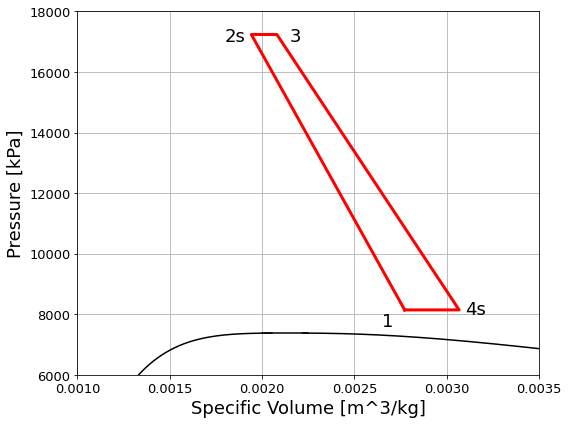

In [32]:
plt.figure(figsize=(8,6), tight_layout=True)

plt.plot(V_CO2_1, P_CO2, 'k', linewidth = 1.5 )
plt.plot(V_CO2_2, P_CO2, 'k', linewidth = 1.5 )
plt.plot(V_merge, P_merge, 'k',linewidth = 1.5)
plt.plot(V_states, P_states, 'r', linewidth = 3 )
plt.grid(True)
plt.xlabel('Specific Volume [m^3/kg]', fontsize = 18)
plt.ylabel('Pressure [kPa]', fontsize = 18)
#plt.text(.002, 4000, 'Two-phase Region', fontsize = 18,
        #bbox = dict(facecolor = 'white'))
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.axis([0.001,.0035,6000,18000])

plt.text(.00265, 7600, '1', fontsize = 18)
plt.text(.0018, 17000, '2s', fontsize = 18)
plt.text(.00215, 17000, '3', fontsize = 18)
plt.text(.0031, 8000, '4s', fontsize = 18)

#plt.savefig('P-V_Diagram.png',bbox_inches='tight')
plt.show()